In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [2]:
def show_image_plt(img_rgb):
    #rgb_carrot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)

***height (rows), width(cols)***

In [3]:
def resize_image(vegi):
    height, width, c = vegi.shape
    new_height = 100
    ratio = new_height / height 
    new_width = int(width * ratio)
    dimensions = (new_width, new_height)
    print(dimensions)
    resized_img = cv2.resize(vegi, dimensions, interpolation=cv2.INTER_LINEAR)
    print("New shape:      ", resized_img.shape)

    return resized_img

# current values for borders they roughly fit to the real hsv values. I test it for brown onion, carrot, brown potato with
# white background, respectively
def mask_image(img_hsv, img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_hsv, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()
    return result
    

def resize_to_square(vegi):
    img_size = 128
    height, width = vegi.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        crop_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        crop_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        crop_img = r_img[0:img_size, 0:img_size]

    if(crop_img.shape[0] != img_size or crop_img.shape[1] != img_size):
        crop_img = r_img[0:img_size, 0:img_size]

    return crop_img


def flip_image_and_show(img):
    # flip vertical
    img_v = cv2.flip(img, 0)
    #show_image_plt(onion_sq_v)

    #flip horizontal
    img_h = cv2.flip(img, 1)
    #show_image_plt(onion_sq_h)

    #flip vertical + horizontal
    img_vh = cv2.flip(img, -1)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #1 row, 3 cols
    fig.tight_layout(h_pad=4)
    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_v)
    axarr[0][1].set_title("Flip Vertical")
    axarr[1][0].imshow(img_h)
    axarr[1][0].set_title("Flip Horizontal")
    axarr[1][1].imshow(img_vh)
    axarr[1][1].set_title("Flip Vertical + Horizontal")
    fig.suptitle('Flipped Images')
    plt.subplots_adjust(top = 0.85)


def rotate_image_and_show(img):
    # rotate 90 degree clockwise
    img_r90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    #show_image_plt(onion_sq_v)

    #rotate 180 degree
    img_r180 = cv2.rotate(img, cv2.ROTATE_180)
    #show_image_plt(onion_sq_h)

    #rotate 90 degree counterclockwise
    img_rcw90 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #2 row, 2 cols
    fig.tight_layout(h_pad=4)

    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_r90)
    axarr[0][1].set_title("+ 90")
    axarr[1][0].imshow(img_r180)
    axarr[1][0].set_title("+ 180")
    axarr[1][1].imshow(img_rcw90)
    axarr[1][1].set_title("- 90")

    fig.suptitle('Rotated Images')
    plt.subplots_adjust(top = 0.85)


def draw_bounding_box(img, low_threshold, high_threshold):
    # the thresholds are used as gradients thresholds. 
    # Something like, gradients smaller than the low_threshold or between the thresholds are ignored 
    result = img.copy()
    gray_square_onion = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_square_onion, low_threshold, high_threshold, cv2.THRESH_BINARY)[1]

    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        # The idea is only keep bigger bounding boxes. Probably it presents the object
        if w > 22 and h > 0.5:
            cv2.rectangle(result, (x, y), (x+w, y+h), (100, 0, 255), 1)
            ROI = img[y:y+h, x:x+w]
            print(f"ROI:. Size of Bounding Box: w = {w} / h = {h}")
        else:
            continue
    show_image_plt(result)


def plot_color_space_rgb_to_hsv(img_rgb, convert_to_hsv=True):
    copy_rgb = img_rgb.copy()
    img_hsv = copy_rgb
    x_label = "R (X)"
    y_label = "G (Y)"
    z_label = "B (Z)"

    if convert_to_hsv:
        img_hsv = cv2.cvtColor(copy_rgb, cv2.COLOR_RGB2HSV)
        x_label = "Hue X"
        y_label = "Saturation Y"
        z_label = "Value Z"

    pixel_colors = copy_rgb.reshape((np.shape(copy_rgb)[0]*np.shape(copy_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    x, y, z = cv2.split(img_hsv)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(x.flatten(), y.flatten(), z.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_zlabel(z_label)
    plt.show()


def print_color_values(img):
    for row in range(0, img.shape[1]):
        for col in range(0, img.shape[1]):
            print(f"Row {row}: Spalte {col} {img[row, col]}")

https://realpython.com/python-opencv-color-spaces/

The Code below is for data augmentation. It is a technique for enlarging a dataset.
It will use the standard techniques like horizontal & vertical flipping and rotation.

Load Images from personal cloud storage

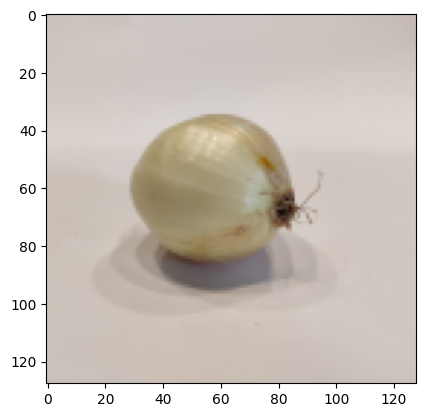

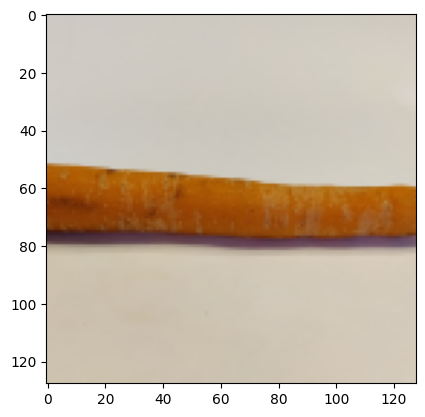

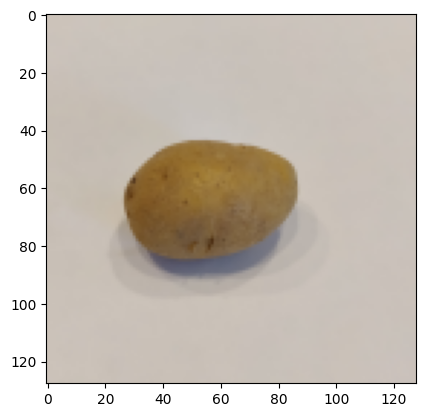

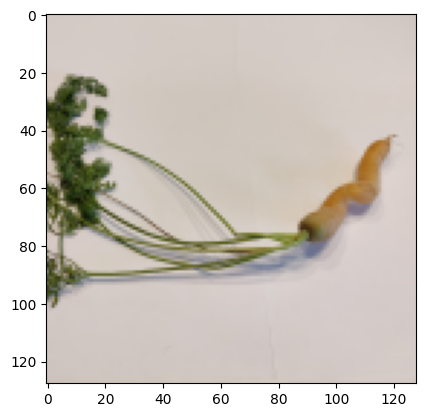

In [4]:
path = "G:\Meine Ablage\Images_AI_Project\zwiebel_jpg\zwiebel_14.jpg"
onion = cv2.imread(path.replace("\\","/"))
onion = cv2.cvtColor(onion, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg\karotte_46.jpg"
carrot = cv2.imread(path.replace("\\","/"))
carrot = cv2.cvtColor(carrot, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg\karotte_trieb_13.jpg"
carrot_trieb = cv2.imread(path.replace("\\","/"))
carrot_trieb = cv2.cvtColor(carrot_trieb, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\kartoffel_jpg\kartoffel_122.jpg"
potato = cv2.imread(path.replace("\\","/"))
potato = cv2.cvtColor(potato, cv2.COLOR_BGR2RGB)

onion_sq = resize_to_square(onion)
carrot_sq = resize_to_square(carrot)
potato_sq = resize_to_square(potato)
carrot_trieb_sq = resize_to_square(carrot_trieb)

show_image_plt(onion_sq)
show_image_plt(carrot_sq)
show_image_plt(potato_sq)
show_image_plt(carrot_trieb_sq)

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

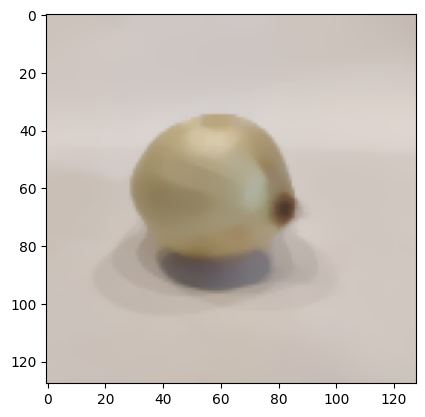

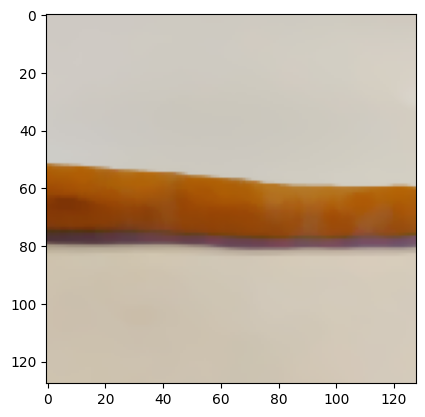

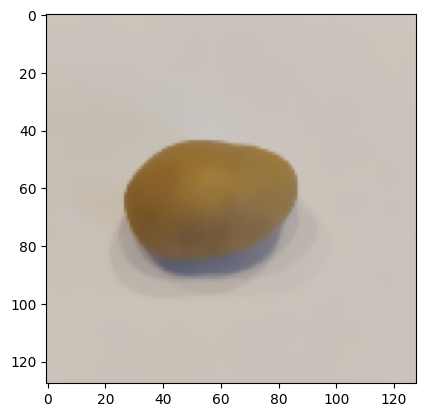

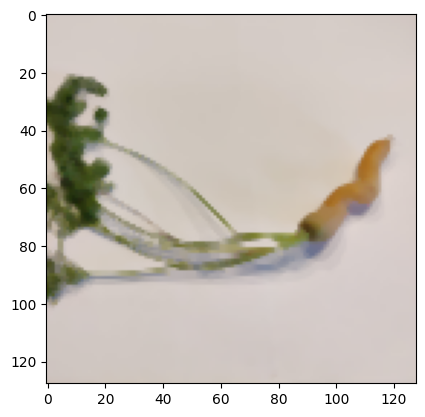

In [114]:
median_onion = cv2.medianBlur(onion_sq, 7)
show_image_plt(median_onion)

median_carrot = cv2.medianBlur(carrot_sq, 7)
show_image_plt(median_carrot)

median_potato = cv2.medianBlur(potato_sq, 7)
show_image_plt(median_potato)

median_carrot_trieb = cv2.medianBlur(carrot_trieb_sq, 3)
show_image_plt(median_carrot_trieb)

In [73]:
print_color_values(median_carrot)

Row 0: Spalte 0 [206 201 195]
Row 0: Spalte 1 [206 201 195]
Row 0: Spalte 2 [206 201 195]
Row 0: Spalte 3 [206 201 195]
Row 0: Spalte 4 [206 201 195]
Row 0: Spalte 5 [206 201 195]
Row 0: Spalte 6 [205 200 195]
Row 0: Spalte 7 [205 200 195]
Row 0: Spalte 8 [205 201 195]
Row 0: Spalte 9 [206 201 195]
Row 0: Spalte 10 [206 201 195]
Row 0: Spalte 11 [206 201 195]
Row 0: Spalte 12 [206 201 195]
Row 0: Spalte 13 [206 201 195]
Row 0: Spalte 14 [206 201 195]
Row 0: Spalte 15 [206 201 195]
Row 0: Spalte 16 [206 201 195]
Row 0: Spalte 17 [206 201 195]
Row 0: Spalte 18 [206 201 195]
Row 0: Spalte 19 [206 201 195]
Row 0: Spalte 20 [206 201 195]
Row 0: Spalte 21 [206 201 195]
Row 0: Spalte 22 [206 201 195]
Row 0: Spalte 23 [206 201 195]
Row 0: Spalte 24 [206 201 195]
Row 0: Spalte 25 [206 201 195]
Row 0: Spalte 26 [206 201 195]
Row 0: Spalte 27 [206 201 195]
Row 0: Spalte 28 [206 201 195]
Row 0: Spalte 29 [206 201 195]
Row 0: Spalte 30 [206 201 195]
Row 0: Spalte 31 [206 201 194]
Row 0: Spalte 32 [

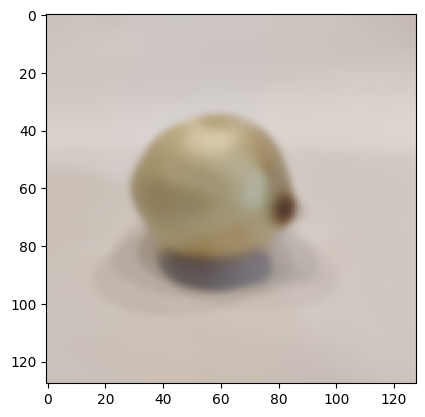

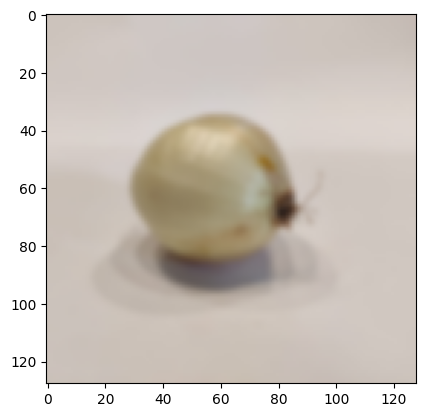

In [74]:
gaussian_onion = cv2.GaussianBlur(median_onion,(5,5),0)
show_image_plt(gaussian_onion)

gaussian_onion = cv2.GaussianBlur(onion_sq,(5,5),0)
show_image_plt(gaussian_onion)

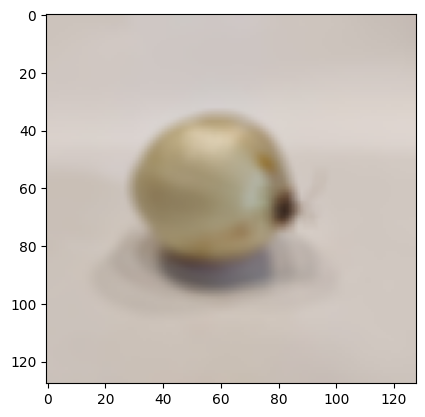

In [75]:
# Creates a 1-D Gaussian kernel
a = cv2.getGaussianKernel(5,5)

# Apply the above Gaussian kernel. Here, I
# have used the same kernel for both X and Y
b = cv2.sepFilter2D(onion_sq,-1,a,a)
show_image_plt(b)

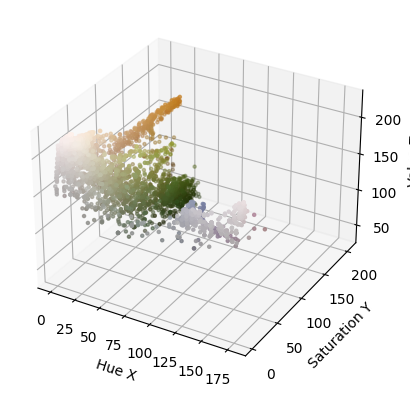

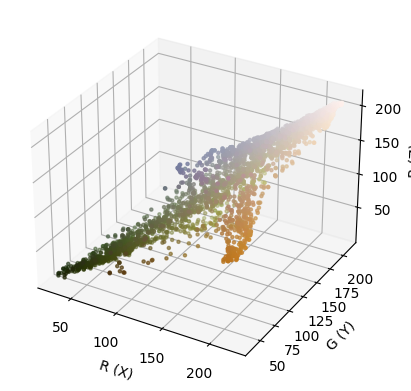

In [115]:
#plot_color_space_rgb_to_hsv(median_onion, convert_to_hsv=False)
#plot_color_space_rgb_to_hsv(median_onion, convert_to_hsv=True)
plot_color_space_rgb_to_hsv(median_carrot_trieb, convert_to_hsv=True)
plot_color_space_rgb_to_hsv(median_carrot_trieb, convert_to_hsv=False)

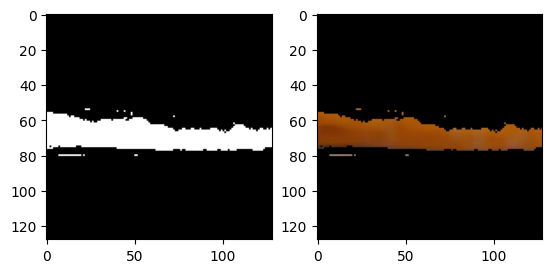

ROI:. Size of Bounding Box: w = 128 / h = 22


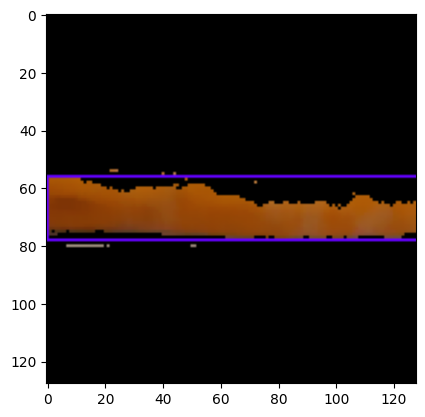

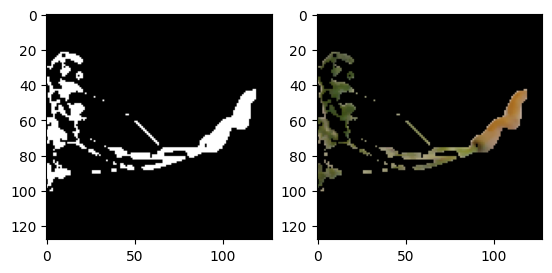

ROI:. Size of Bounding Box: w = 84 / h = 46


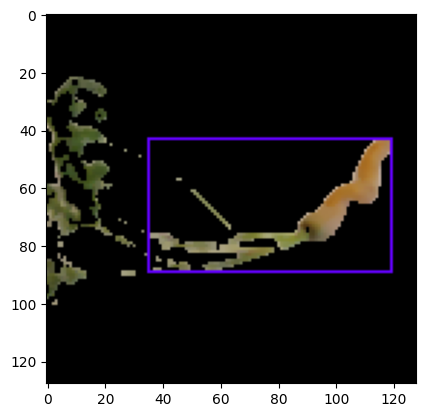

In [116]:
median_carrot_hsv = cv2.cvtColor(median_carrot, cv2.COLOR_RGB2HSV)
result = mask_image(median_carrot_hsv, median_carrot, border_low=(8, 50, 75), border_high=(15, 255, 200))
draw_bounding_box(result, 255/3, 255)

median_carrot_trieb_hsv = cv2.cvtColor(median_carrot_trieb, cv2.COLOR_RGB2HSV)
result = mask_image(median_carrot_trieb_hsv, median_carrot_trieb, border_low=(8, 50, 75), border_high=(50, 255, 200))
draw_bounding_box(result, 255/3, 255)

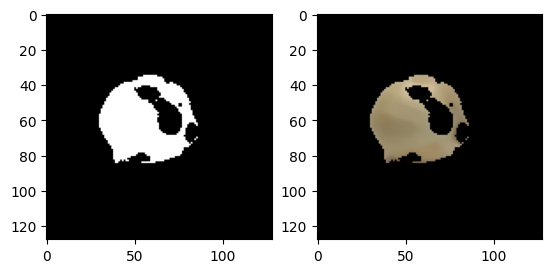

ROI:. Size of Bounding Box: w = 56 / h = 50


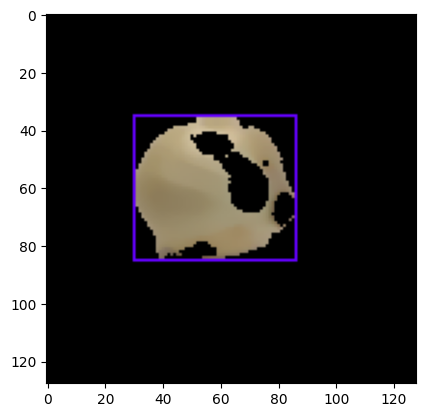

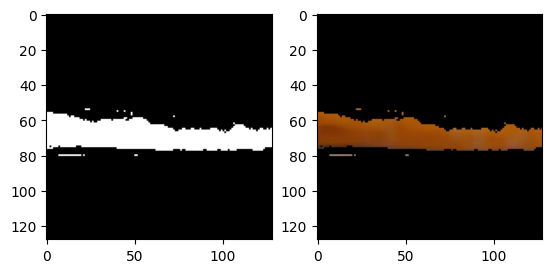

ROI:. Size of Bounding Box: w = 128 / h = 22


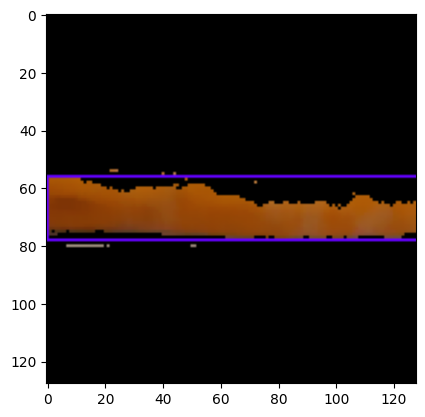

In [99]:
median_onion_hsv = cv2.cvtColor(median_onion, cv2.COLOR_RGB2HSV)
result = mask_image(median_onion_hsv, median_onion, border_low=(15, 60, 100), border_high=(175, 100, 255))
draw_bounding_box(result, 255/3, 255)

median_carrot_hsv = cv2.cvtColor(median_carrot, cv2.COLOR_RGB2HSV)
result = mask_image(median_carrot_hsv, median_carrot, border_low=(8, 50, 75), border_high=(15, 255, 200))
draw_bounding_box(result, 255/3, 255)

In [112]:
print_color_values(median_carrot_trieb_hsv)

Row 0: Spalte 0 [ 11  17 210]
Row 0: Spalte 1 [ 11  17 210]
Row 0: Spalte 2 [ 11  17 210]
Row 0: Spalte 3 [ 11  17 210]
Row 0: Spalte 4 [ 11  17 210]
Row 0: Spalte 5 [ 11  17 210]
Row 0: Spalte 6 [ 11  17 210]
Row 0: Spalte 7 [ 11  17 210]
Row 0: Spalte 8 [ 12  18 211]
Row 0: Spalte 9 [ 12  18 211]
Row 0: Spalte 10 [ 11  17 211]
Row 0: Spalte 11 [ 11  17 211]
Row 0: Spalte 12 [ 11  17 211]
Row 0: Spalte 13 [ 11  17 211]
Row 0: Spalte 14 [ 11  17 211]
Row 0: Spalte 15 [ 11  17 211]
Row 0: Spalte 16 [ 11  17 211]
Row 0: Spalte 17 [ 12  18 212]
Row 0: Spalte 18 [ 11  17 212]
Row 0: Spalte 19 [ 11  17 212]
Row 0: Spalte 20 [ 11  17 212]
Row 0: Spalte 21 [ 11  17 212]
Row 0: Spalte 22 [ 11  17 212]
Row 0: Spalte 23 [ 11  17 212]
Row 0: Spalte 24 [ 12  18 212]
Row 0: Spalte 25 [ 13  19 212]
Row 0: Spalte 26 [ 13  19 212]
Row 0: Spalte 27 [ 13  19 212]
Row 0: Spalte 28 [ 13  19 212]
Row 0: Spalte 29 [ 13  19 212]
Row 0: Spalte 30 [ 13  19 212]
Row 0: Spalte 31 [ 13  19 212]
Row 0: Spalte 32 [

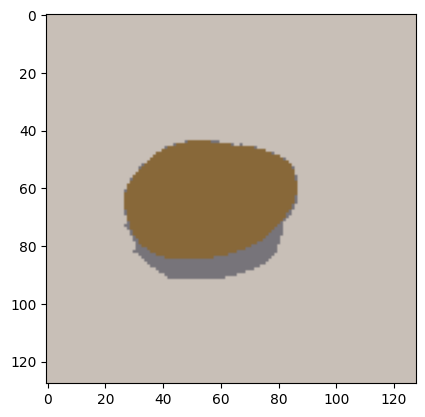

In [36]:
# KMeans Processing
#potato_hsv = cv2.cvtColor(potato_sq, cv2.COLOR_RGB2HSV)
onion_2D = potato_sq.reshape((-1,3)) #rgb
onion_2D = np.float32(onion_2D)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10

ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((potato_sq.shape))

show_image_plt(result_image)

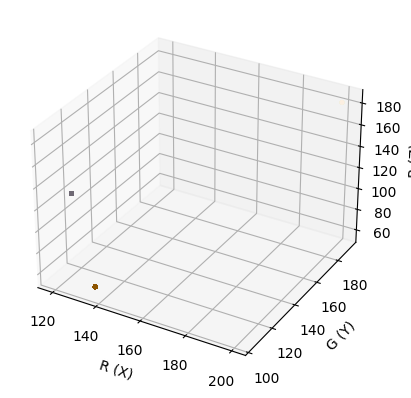

In [37]:
plot_color_space_rgb_to_hsv(result_image, convert_to_hsv=False)

In [38]:
print(center)

[[200 191 183]
 [136 104  57]
 [119 116 122]]


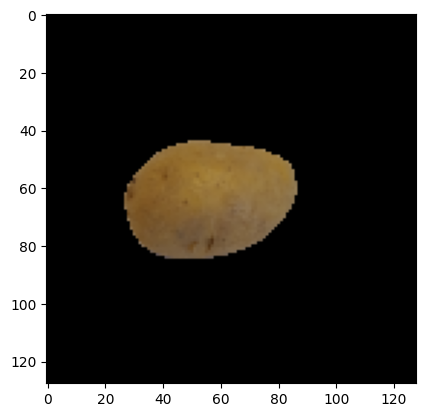

ROI:. Size of Bounding Box: w = 60 / h = 41


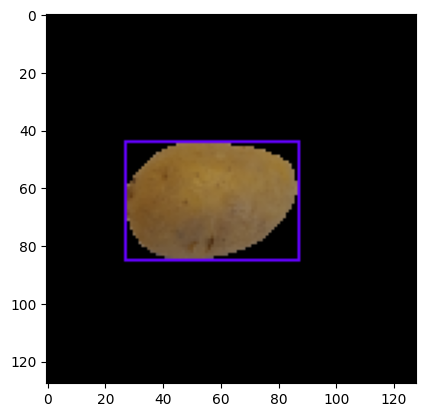

In [39]:
    #15, 23, 135
#result = mask_image(result_image, potato_sq, border_low=(130, 103, 64), border_high=(201, 193, 185))

mask = cv2.inRange(result_image, (135, 103, 56), (137, 105, 58))
result_mask = cv2.bitwise_and(potato_sq, potato_sq, mask=mask)
show_image_plt(result_mask)

draw_bounding_box(result_mask, 0, 255)